In [1]:
import sklearn
import numpy as np
from tqdm import tqdm_notebook, tnrange

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data_x = np.load("../../tile_data/processed/data_x_l2a_processed.npy")
data_y = np.load("../../tile_data/processed/data_y_l2a_processed.npy")
lengths = np.load("../../tile_data/processed/length_l2a_processed.npy")

data_x = np.delete(data_x, 14, -1) 

In [3]:
from scipy.ndimage import median_filter
from skimage.transform import resize
for sample in tnrange(0, len(data_x)):
    filtered = median_filter(data_x[sample, 0, :, :, 10], size = 5)
    filtered = np.reshape(filtered, (8, 2, 8, 2))
    filtered = np.mean(filtered, axis = (1, 3))
    filtered = resize(filtered, (16, 16), 0)
    data_x[sample, :, :, :, 10] = np.stack([filtered] * 24)
    
#data_x = np.delete(data_x, 10, -1)
print(data_x.shape)


(4390, 24, 16, 16, 16)


In [4]:
below_1 = [i for i, val in enumerate(data_x[:, :, :, :, :-2]) if np.min(val) < -1.5]
above_1 = [i for i, val in enumerate(data_x[:, :, :, :, :-2]) if np.max(val) > 1.5]
min_vals = [np.min(val) for i, val in enumerate(data_x[:, :, :, :, :-2]) if np.min(val) < -1.5]
max_vals = [np.max(val) for i, val in enumerate(data_x[:, :, :, :, :-2]) if np.max(val) > 1.5]
nans = [i for i, val in enumerate(data_x) if np.sum(np.isnan(val)) > 0]
oob_vals = [i for i, val in enumerate(data_x) if np.max(val[:, :, :, 0]) > 0.7]
print(oob_vals)

outliers = below_1 + above_1 + nans + oob_vals
outliers = list(set(outliers))
print("The outliers are: {}, totalling {}".format(outliers, len(outliers)))
print("\n")
print(min_vals, max_vals)
data_x = data_x[[x for x in range(0, len(data_x)) if x not in outliers]]
data_y = data_y[[x for x in range(0, len(data_y)) if x not in outliers]]
lengths = lengths[[x for x in range(0, len(lengths)) if x not in outliers]]

[3906, 3913, 3915, 3916, 3921, 3949, 3972, 3984, 3985, 4009, 4016, 4058, 4060, 4092, 4096, 4133, 4179, 4186, 4189, 4191, 4310, 4311, 4312, 4319, 4321, 4333, 4335, 4339, 4343, 4348, 4352, 4357, 4360, 4365, 4366, 4376, 4383]
The outliers are: [4096, 4352, 3972, 4357, 4360, 4365, 4366, 3984, 3985, 2071, 4376, 4383, 4133, 4009, 4141, 4016, 3906, 3913, 3915, 3916, 3921, 4179, 4310, 4311, 4312, 4058, 4186, 4060, 4189, 4319, 4191, 4321, 3943, 4092, 3949, 4333, 3951, 4335, 4339, 1525, 4343, 4348], totalling 42


[-1.5637276, -1.508853, -1.71253, -1.6176922, -1.6507452, -1.7271925] [1.5485176, 1.5207762, 1.5558996, 1.6954132, 1.6817182, 1.5697637, 1.7376012, 1.5934502, 1.6265625, 1.6901331]


In [5]:
min_all = [0.020395646858960392,
 0.03833778686821461,
 0.022913980782032013,
 0.08838867269456387,
 0.05731564749032259,
 0.0796274145692587,
 0.08639285631477833,
 0.08918419919908048,
 0.07416137464344502,
 0.04398707151412964,
 0.0,
 0.008659180235117674,
 -0.0134716229327023,
 0.006902076792903247,
 0.006362500241957605,
 4.999999873689376e-05]

max_all = [0.18219037026166907,
 0.27367106080055237,
 0.3996005910634992,
 0.4859166720509528,
 0.4492199122905731,
 0.46700127094984045,
 0.49433933556079857,
 0.5116616946458816,
 0.6353135156631469,
 0.5636022371053693,
 0.3590170443058014,
 0.693415229320526,
 0.3948741647601127,
 0.6290205121040344,
 0.8152220940589849,
 0.14367499947547913]



min_all = []
max_all = []

for band in range(0, data_x.shape[-1]):
    mins = np.percentile(data_x[:, :, :, :, band], 1)
    maxs = np.percentile(data_x[:, :, :, :, band], 99)
    #mins, maxs = (np.min(data_x[:, :, :, :, band]), np.max(data_x[:, :, :, :, band]))
    #mins = min_all[band]
    #maxs = max_all[band]
    data_x[:, :, :, :, band] = np.clip(data_x[:, :, :, :, band], mins, maxs)
    midrange = (maxs + mins) / 2
    rng = maxs - mins
    standardized = (data_x[:, :, :, :, band] - midrange) / (rng / 2)
    data_x[:, :, :, :, band] = standardized
    
    min_all.append(mins)
    max_all.append(maxs)
    
print("The data has been scaled to [{}, {}]".format(np.min(data_x), np.max(data_x)))

The data has been scaled to [-1.0000001192092896, 1.000000238418579]


In [6]:
data_x = np.mean(data_x, axis = 1)
data_x = data_x[:, 1:15, 1:15, :]
data_x = np.reshape(data_x, (data_x.shape[0]*data_x.shape[1]*data_x.shape[2], data_x.shape[-1]))
data_y = np.reshape(data_y, (data_y.shape[0]*14*14))

In [13]:
test_x = np.load("../../tile_data/processed/test_x_l2a_processed.npy")
test_y = np.load("../../tile_data/processed/test_y_l2a_processed.npy")
test_lengths = np.load("../../tile_data/processed/test_length_l2a_processed.npy")

test_x = np.delete(test_x, 14, -1)
#test_x = np.delete(test_x, 13, -1)


below_1 = [i for i, val in enumerate(test_x[:, :, :, :, :-2]) if np.min(val) < -1.67]
above_1 = [i for i, val in enumerate(test_x[:, :, :, :, :-2]) if np.max(val) > 1.67]
min_vals = [np.min(val) for i, val in enumerate(test_x[:, :, :, :, :-2]) if np.min(val) < -1.5]
max_vals = [np.max(val) for i, val in enumerate(test_x[:, :, :, :, :-2]) if np.max(val) > 1.5]
nans = [i for i, val in enumerate(test_x) if np.sum(np.isnan(val)) > 0]
outliers = below_1 + above_1 + nans
outliers = list(set(outliers))
print("The outliers are: {}, totalling {}".format(outliers, len(outliers)))
print("\n")
print(min_vals, max_vals)

for i in range(len(test_x)):
    mins = np.min(test_x[i, :, :, :, :])
    maxs = np.max(test_x[i, :, :, :, :])
    if mins < -1 or maxs > 1:
        offender_max = np.argmax(np.max(test_x[i, :, :, :, :], (0, 1, 2)), -1)
        offender_min = np.argmin(np.min(test_x[i, :, :, :, :], (0, 1, 2)), -1)
        
        print("{} Offender max/min: {} {}".format(i, offender_max, offender_min))
test_x = test_x[[x for x in range(0, len(test_x)) if x not in outliers]]
test_y = test_y[[x for x in range(0, len(test_y)) if x not in outliers]]
test_lengths = test_lengths[[x for x in range(0, len(test_lengths)) if x not in outliers]]

for sample in tnrange(0, len(test_x)):
    filtered = median_filter(test_x[sample, 0, :, :, 10], size = 5)
    filtered = np.reshape(filtered, (8, 2, 8, 2))
    filtered = np.mean(filtered, axis = (1, 3))
    filtered = resize(filtered, (16, 16), 0)
    test_x[sample, :, :, :, 10] = np.stack([filtered] * 24)

#test_x = np.delete(test_x, 10, -1)
    
for band in range(0, test_x.shape[-1]):
    mins = min_all[band]
    maxs = max_all[band]
    test_x[:, :, :, :, band] = np.clip(test_x[:, :, :, :, band], mins, maxs)
    midrange = (maxs + mins) / 2
    rng = maxs - mins
    standardized = (test_x[:, :, :, :, band] - midrange) / (rng / 2)
    test_x[:, :, :, :, band] = standardized
    
    
print("The data has been scaled to [{}, {}]".format(np.min(test_x), np.max(test_x)))
print(test_x.shape)

The outliers are: [1056, 1064, 714, 750, 1071, 593, 1105, 1087], totalling 8


[-1.7179548, -1.5627671, -1.8532804, -1.7344598, -1.566039, -1.5506328, -1.5647379, -1.5482582, -1.5288317, -1.6640986, -1.5696894, -1.6236508, -1.6086293, -1.8026409, -1.6395152, -1.7323623, -1.8079871, -1.6267077] [1.6422757, 1.6066049, 1.7172077, 1.5512294, 1.5134994, 1.6136878, 1.644342, 1.5873938, 1.7966671, 1.7034032, 1.5901011, 1.7489257, 1.6376961, 1.6454076, 1.6791666, 1.7280316]
0 Offender max/min: 14 12
2 Offender max/min: 14 10
7 Offender max/min: 14 15
9 Offender max/min: 14 10
12 Offender max/min: 14 12
17 Offender max/min: 14 10
18 Offender max/min: 14 10
19 Offender max/min: 14 12
21 Offender max/min: 14 12
25 Offender max/min: 14 10
33 Offender max/min: 14 10
41 Offender max/min: 14 10
52 Offender max/min: 14 10
53 Offender max/min: 14 12
54 Offender max/min: 14 12
55 Offender max/min: 14 12
58 Offender max/min: 14 12
61 Offender max/min: 14 12
63 Offender max/min: 14 12
68 Offender max/min:


The data has been scaled to [-1.0000001192092896, 1.000000238418579]
(1103, 24, 16, 16, 16)


In [14]:
test_x = np.mean(test_x, axis = 1)
test_x = test_x[:, 1:15, 1:15, :]
test_x = np.reshape(test_x, (test_x.shape[0]*test_x.shape[1]*test_x.shape[2], test_x.shape[-1]))
test_y = np.reshape(test_y, (test_y.shape[0]*14*14))

In [9]:
countries = {'africaeast-test': [0, 34],
 'africawest-test': [35, 96],
 'cameroon-test': [97, 135],
 'ethiopia-test': [136, 248],
 'ghana-test': [249, 282],
 'ghana-test-large': [283, 318],
 'global-test': [319, 417],
 'india-test': [418, 468],
 'kenya-test': [469, 557],
 'lac-north-test': [558, 598],
 'lac-south-test': [599, 640]}

In [122]:
from sklearn.ensemble import RandomForestRegressor
#clf = RandomForestRegressor(n_estimators=100, random_state=0)
#clf.fit(data_x, data_y)
#y_pred = clf.predict(test_x)

In [10]:
from joblib import dump, load
clf = load('../../models/randomforest/model.joblib') 
    

In [127]:
#from joblib import dump, load
#dump(clf, '../../models/randomforest/model.joblib') 

['../../models/randomforest/model.joblib']

In [17]:
y_pred = clf.predict(test_x)
# .43 global
y_pred[np.where(y_pred >= 0.43)] = 1.
y_pred[np.where(y_pred < 0.43)] = 0.

In [18]:
print(sklearn.metrics.classification_report(test_y, y_pred))

              precision    recall  f1-score   support

         0.0       0.88      0.90      0.89    137440
         1.0       0.82      0.78      0.80     78748

    accuracy                           0.86    216188
   macro avg       0.85      0.84      0.85    216188
weighted avg       0.86      0.86      0.86    216188



In [59]:
path = "../../tile_data/tanzania/processed/"

def standardize_tile(arr):
    for x in range(0, arr.shape[-1]):
        mins = min_all[x]
        maxs = max_all[x]
        arr[:, :, :, x] = np.clip(arr[:, :, :, x], mins, maxs)
        midrange = (maxs + mins) / 2
        rng = maxs - mins
        standardized = (arr[:, :, :, x] - midrange) / (rng / 2)
        arr[:, :, :, x] = standardized
        mins, maxs = (np.min(arr[:, :, :, x]), np.max(arr[:, :, :, x]))
    return arr

def predict_tile(y, x, path = path):
    tile_x = np.load(path + str(y) + "/" + str(x) + ".npy")
    tile_x = np.delete(tile_x, 14, -1)
    tile_x = standardize_tile(tile_x)
    tile_x = np.mean(tile_x, axis = 0)
    tile_x[np.isnan(tile_x)] = 0.
    tile_x = tile_x[1:-1, 1:-1, :]
     
    tile_x = np.reshape(tile_x, (tile_x.shape[0]*tile_x.shape[1], tile_x.shape[-1]))
    tile_y = clf.predict(tile_x)
    tile_y = np.reshape(tile_y, (126, 126))
    return tile_y

tile_y = predict_tile(0, 1)

In [61]:
all_preds = []
for row in tnrange(0, 5):
    pred_i = [predict_tile(row, col) for col in range(0, 5)]
    pred_i = np.concatenate(pred_i, axis = 1)
    all_preds.append(pred_i)
all_preds.reverse()
stacked = np.concatenate(all_preds, axis = 0)
#stacked = stacked[400:600, 400:500]

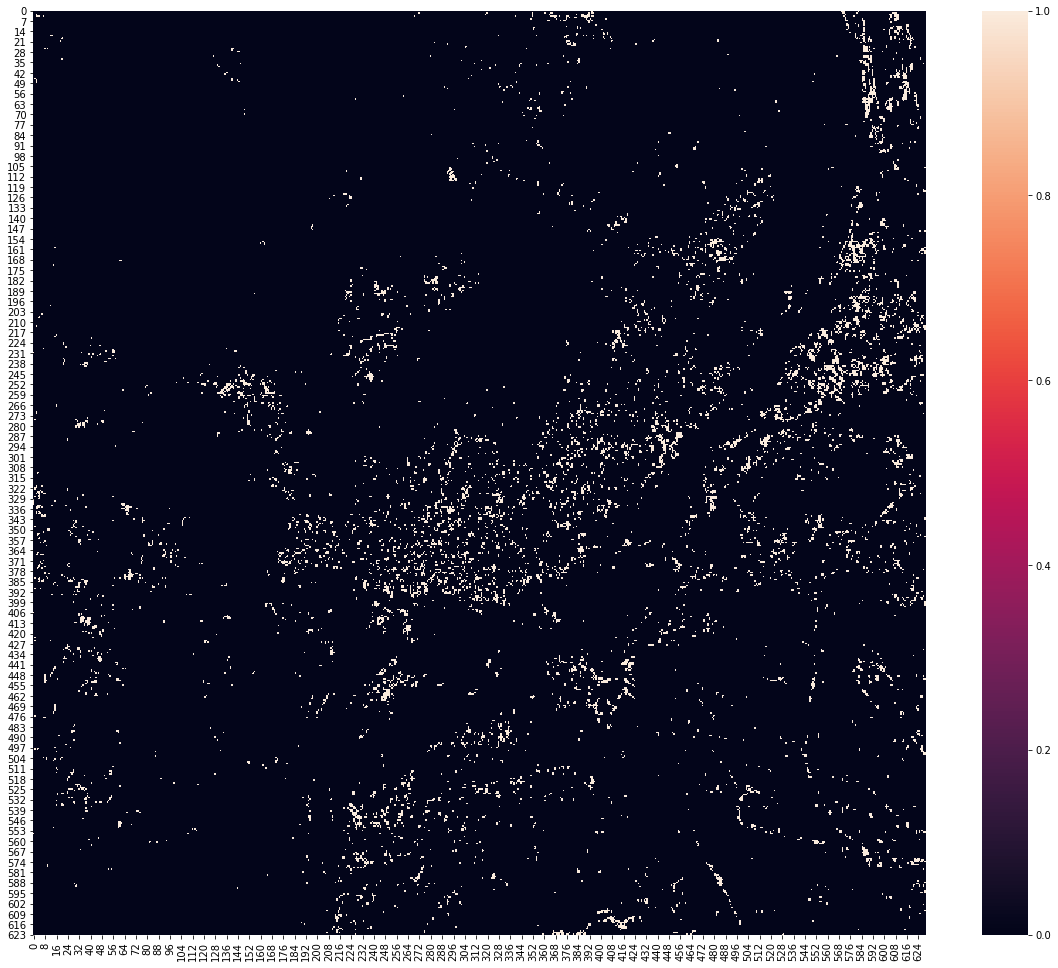

In [62]:
plt.figure(figsize=(20, 17))
stacked[np.where(stacked >= 0.6)] = 1.
stacked[np.where(stacked < 0.6)] = 0.
sns.heatmap(stacked)


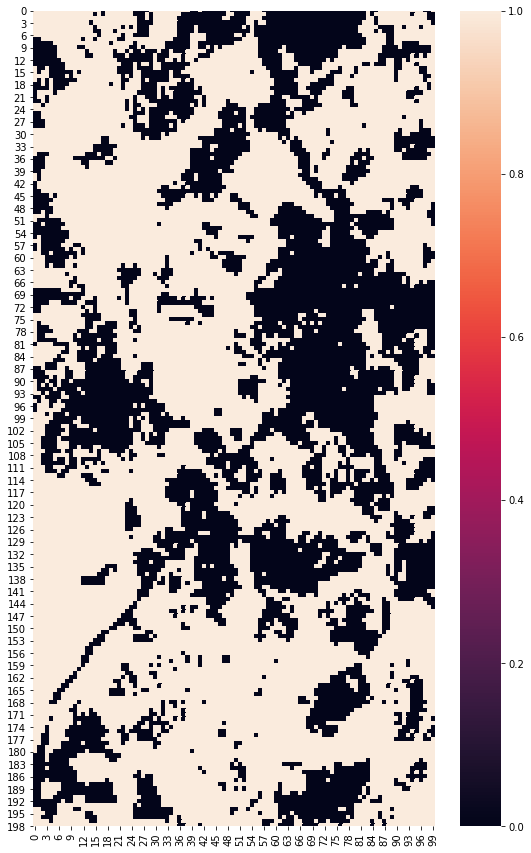

In [63]:
plt.figure(figsize=(9, 15)) ()
# HONDURAS IS 200:400, 540:640 in (5, 10 row), (10, 20 coly)
sns.heatmap(stacked[200:400, 1800-1260:1900-1260])

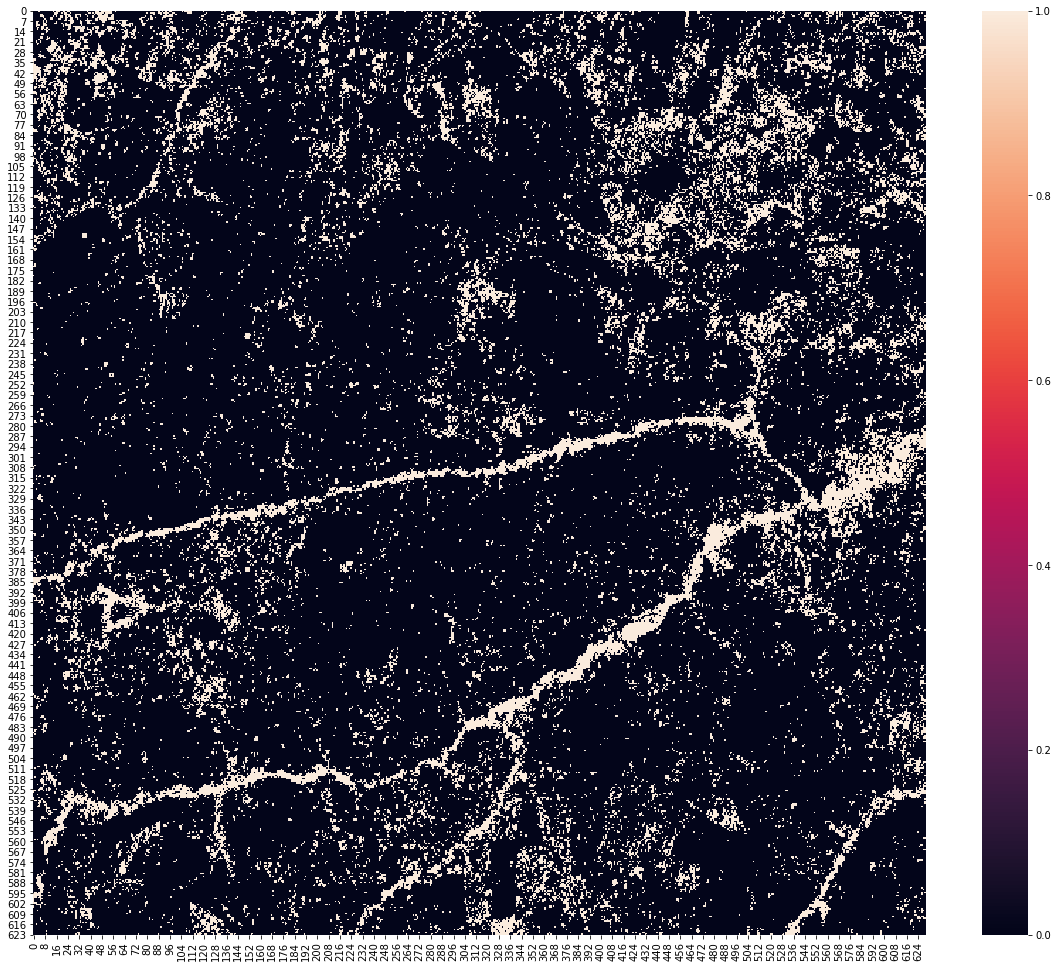

In [138]:
plt.figure(figsize=(20, 17))
stacked[np.where(stacked >= 0.4)] = 1.
stacked[np.where(stacked < 0.4)] = 0.
sns.heatmap(stacked)

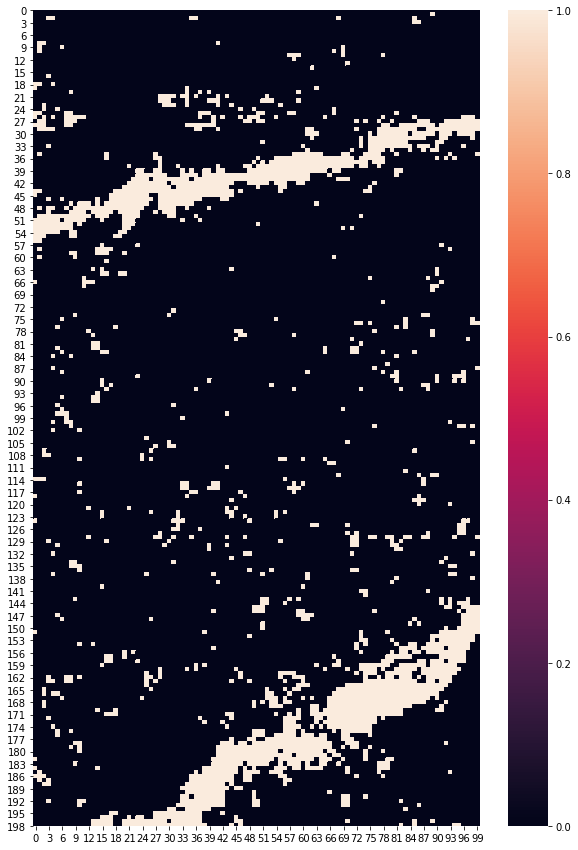

In [140]:
# GHANA is 250:450, 350:450
stacked = stacked[250:450, 350:450]
plt.figure(figsize=(10, 15))
sns.heatmap(stacked)

# Metrics

In [19]:
preds = y_pred
trues = test_y
from sklearn.metrics import f1_score
def compute_f1_score_at_tolerance(true, pred, tolerance = 1):
    fp = 0
    tp = 0
    fn = 0
    
    tp = np.zeros_like(true)
    fp = np.zeros_like(true)
    fn = np.zeros_like(true)
    
    
    for x in range(true.shape[0]):
        for y in range(true.shape[1]):
            min_x = np.max([0, x-1])
            min_y = np.max([0, y-1])
            max_y = np.min([true.shape[0], y+2])
            max_x = np.min([true.shape[0], x+2])
            if true[x, y] == 1:
                if np.sum(pred[min_x:max_x, min_y:max_y]) > 0:
                    if pred[x, y] == 1:
                        tp[x, y] = 1
                else:
                    fn[x, y] = 1
            if pred[x, y] == 1:
                if np.sum(true[min_x:max_x, min_y:max_y]) > 0:
                    if true[x, y] == 1:
                        tp[x, y] = 1
                else:
                    fp[x, y] = 1    
    return np.sum(tp), np.sum(fp), np.sum(fn)

tp = preds * trues
fn = [1 if x > y else 0 for (x, y) in zip(trues, preds)]
fp = [1 if y > x else 0 for (x, y) in zip(trues, preds)]
tn = (len(test_y) * 196) - np.sum(tp) - np.sum(fn) - np.sum(fp)
print("TP {}, FN {}, FP {}, TN {}".format(np.sum(tp), sum(fn), np.sum(fp), tn))

tps = []
fns = []
fps = []
for i in range(0, len(test_y), 196):
    tps.append(np.sum(tp[i:i+196]))
    fns.append(np.sum(fn[i:i+196]))
    fps.append(np.sum(fp[i:i+196]))
    
    

from sklearn.metrics import f1_score


true_canopy = []
error_canopy = []
pred_canopy = []
f1_hard = []
tp_softs = []
fp_softs = []
fn_softs = []
for i in range(0, len(preds), 196):
    true_canopy.append(np.sum(trues[i:i+196]) / 1.96)
    error_canopy.append(abs(np.sum(preds[i:i+196]) - np.sum(trues[i:i+196])) / 1.96)
    pred_canopy.append(np.sum(preds[i:i+196]) / 1.96)
    f1_hard.append(f1_score(trues[i:i+196], preds[i:i+196]))
    tp_soft, fp_soft, fn_soft = compute_f1_score_at_tolerance(np.array(trues[i:i+196].reshape((14, 14))),
                                                 np.array(preds[i:i+196].reshape((14, 14))))
    tp_softs.append(tp_soft)
    fp_softs.append(fp_soft)
    fn_softs.append(fn_soft)

TP 61786.0, FN 16962, FP 13481, TN 42280619.0


/Users/john.brandt/anaconda3/envs/remote_sensing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/john.brandt/anaconda3/envs/remote_sensing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


In [20]:
precision = np.sum(tp_softs) / (np.sum(tp_softs) + np.sum(fp_softs))
recall = np.sum(tp_softs) / (np.sum(tp_softs) + np.sum(fn_softs))
print(precision, recall, np.mean(error_canopy), np.mean(true_canopy), np.mean(pred_canopy))

0.8932872612662107 0.8872836935449128 10.616222917090681 36.42570355431384 34.81553092678595


In [21]:
import pandas as pd
import math
metrics = pd.DataFrame({'true': true_canopy,
                        'pred': pred_canopy,
                        'f1_hard': f1_hard,
                        'error': error_canopy,
                        'tp': tps,
                        'fp': fps,
                        'fn': fns,
                        'tp_soft': tp_softs,
                        'fp_soft': fp_softs,
                        'fn_soft': fn_softs,
                       })

res = map(lambda x: int(math.floor(np.min([x, 90]) / 10.0)) * 10, true_canopy)
res = [x for x in res]
metrics['group'] = res
metrics['model'] = 'Random Forest'

metrics.to_csv("../../data/metrics/rf-sample.csv")

In [22]:
hard_precisions = metrics.groupby('group').apply(lambda x: (np.sum(x.tp) / np.sum(x.tp + x.fp)))
hard_recalls = metrics.groupby('group').apply(lambda x: (np.sum(x.tp) / np.sum(x.tp + x.fn)))
errors = metrics.groupby('group').apply(lambda x: np.mean(x.error))
hard_f1 = 2 *  ((hard_precisions * hard_recalls) / (hard_precisions + hard_recalls))

precisions = metrics.groupby('group').apply(lambda x: (np.sum(x.tp_soft) / np.sum(x.tp_soft + x.fp_soft)))
recalls = metrics.groupby('group').apply(lambda x: (np.sum(x.tp_soft) / np.sum(x.tp_soft + x.fn_soft)))
soft_f1 = 2 *  ((precisions * recalls) / (precisions + recalls))




In [23]:
new_metrics = pd.DataFrame({'group': [x for x in range(0, 100, 10)],
                            'hard_rec': hard_recalls,
                            'soft_rec': recalls,
                            'hard_prec': hard_precisions,
                            'soft_prec': precisions,
                            'hard_f1': hard_f1,
                            'soft_f1': soft_f1,
                            'error': errors,
                            'model': 'Random Forest'
                           })

new_metrics.to_csv("../../data/metrics/rf.csv")

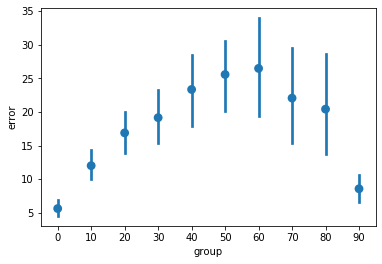

In [17]:
sns.pointplot('group', 'error',
    data=metrics, dodge=True, join=False)

In [18]:
np.nanmean(f1_hard)

0.38970577208712576

In [134]:
metrics['model'] = 'random_forest'
metrics.to_csv("../../data/metrics/random_forest.csv")